
## 1. 기본 정보 확인 (BVH 파일 -> pymo 파싱데이터)

In [9]:
from pymo.parsers import BVHParser

#BVH 파일 경로
BVH_FILE_PATH = "bvh/P01_R01.bvh"


try:
    print(f"'{BVH_FILE_PATH}' 파일 분석을 시작합니다...\n")
    
    # 1. BVH 파일 파싱
    parser = BVHParser()
    parsed_data = parser.parse(BVH_FILE_PATH)

    # 2. 파싱된 데이터에서 핵심 정보 추출
    # 프레임 수: 모션 데이터의 총 행(row)의 개수
    num_frames = len(parsed_data.values)
    
    # 관절 수: 스켈레톤 딕셔너리에 있는 키의 개수
    num_joints = len(parsed_data.skeleton)
    
    # 초당 프레임 수 (FPS)
    fps = parsed_data.framerate

    # 3. 결과 출력
    print("✅ 파싱 결과 분석")
    print("-" * 30)
    print(f"파싱된 프레임 수  : {num_frames}")
    print(f"파싱된 관절 수    : {num_joints}")
    print(f"파싱된 FPS        : {fps:.5f} (초당 프레임)")
    print("-" * 30)
    print("\n이제 BVH 원본 파일을 열어 아래 설명에 따라 값들을 비교해보세요.")

except FileNotFoundError:
    print(f"❌ 오류: 파일을 찾을 수 없습니다. 경로를 확인해주세요: {BVH_FILE_PATH}")
except Exception as e:
    print(f"❌ 예상치 못한 오류가 발생했습니다: {e}")

'bvh/P01_R01.bvh' 파일 분석을 시작합니다...

✅ 파싱 결과 분석
------------------------------
파싱된 프레임 수  : 62506
파싱된 관절 수    : 72
파싱된 FPS        : 0.00840 (초당 프레임)
------------------------------

이제 BVH 원본 파일을 열어 아래 설명에 따라 값들을 비교해보세요.


### ------------------------------------------------------
### 원본 결과 비교
- skeleton (숫자 세어봄): 72개
- Frames: 62506
- Frame Time: 0.0084011134931046619524525645538

## 2. 월드 좌표 기준으로 변경 및 3D 시각화

- 월드 좌표(0,0,0,0,0,0) 기준으로 좌표값 변경 (fk 계산)
- 변환 전(상대 좌표) 데이터와 변환 후(월드 좌표) 데이터 시각화 -> 검증

'bvh/P01_R01.bvh' 파일 파싱 중...
월드 좌표로 변환 중...


c:\Users\김지희\OneDrive - JNE Systech\바탕 화면\project\venv\lib\site-packages\pymo\preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
c:\Users\김지희\OneDrive - JNE Systech\바탕 화면\project\venv\lib\site-packages\pymo\preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
c:\Users\김지희\OneDrive - JNE Systech\

데이터 변환 및 DataFrame 생성 완료.

➡️  두 개의 플롯 창이 나타납니다. 포즈를 비교해보세요.


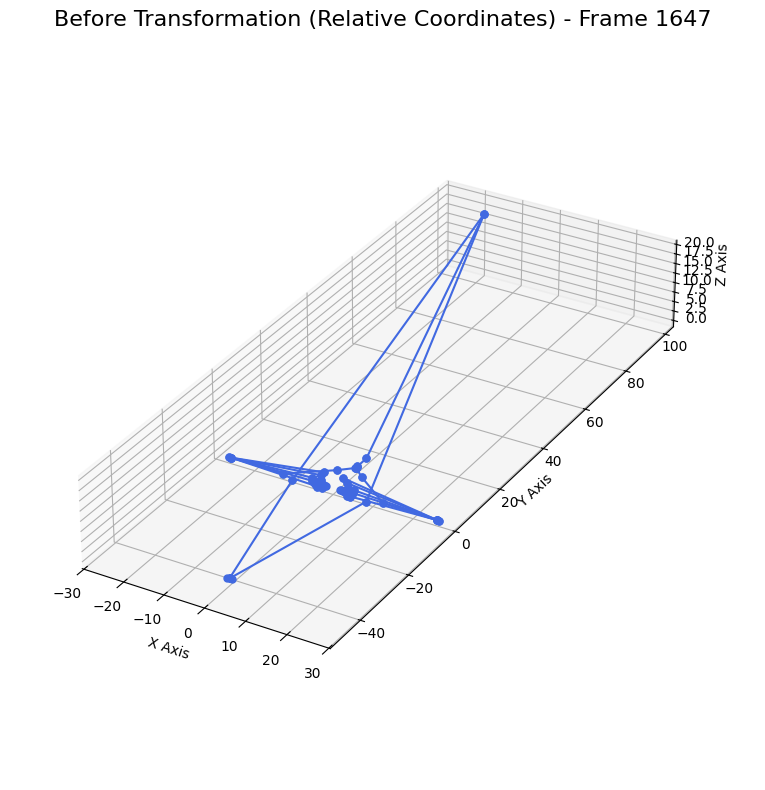

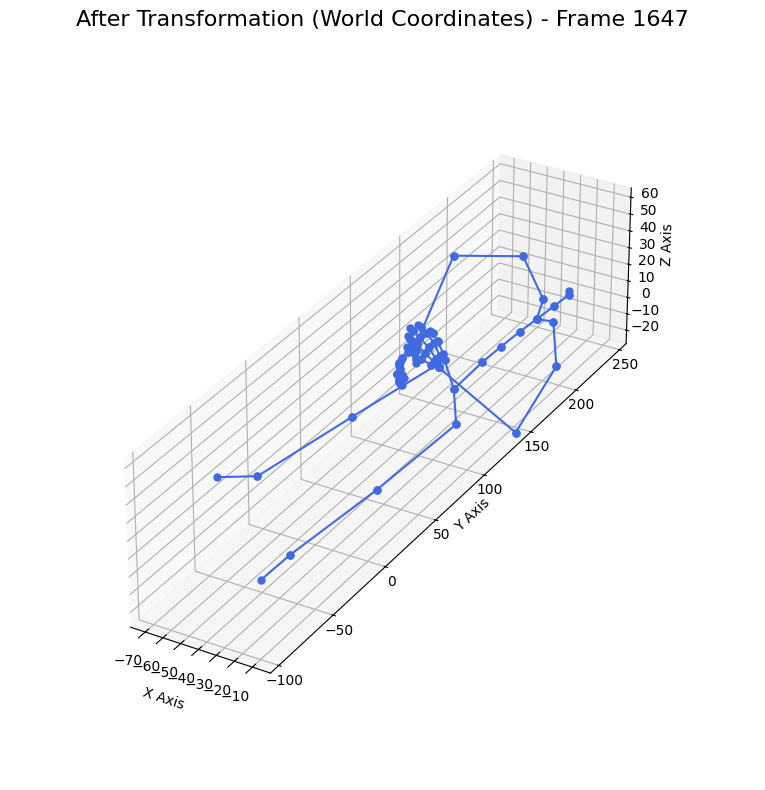

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pymo.parsers import BVHParser
from pymo.preprocessing import MocapParameterizer

def visualize_bvh_pose(frame_number, dataframe, skeleton_dict, title=""):
    """
    주어진 DataFrame과 스켈레톤 구조를 이용해 3D 스켈레톤을 그리는 함수.
    .iloc를 사용하여 정수 위치로 프레임에 접근합니다.
    """
    if frame_number >= len(dataframe):
        print(f"❌ 오류: 프레임 {frame_number}는 존재하지 않습니다. (최대: {len(dataframe)-1})")
        return

    # .iloc를 사용하여 정수 위치로 프레임 데이터에 접근합니다.
    frame_data = dataframe.iloc[frame_number]
    
    joint_positions = {}
    for joint_name in skeleton_dict.keys():
        try:
            # 각 관절의 X, Y, Z 위치를 DataFrame에서 찾습니다.
            pos_x = frame_data[f"{joint_name}_Xposition"]
            pos_y = frame_data[f"{joint_name}_Yposition"]
            pos_z = frame_data[f"{joint_name}_Zposition"]
            joint_positions[joint_name] = np.array([pos_x, pos_y, pos_z])
        except KeyError:
            # 위치 데이터가 없는 관절은 건너뜁니다.
            continue
            
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title, fontsize=16)

    # 스켈레톤의 뼈대를 그립니다.
    for parent_name, parent_info in skeleton_dict.items():
        if 'children' in parent_info:
            for child_name in parent_info['children']:
                if parent_name in joint_positions and child_name in joint_positions:
                    p_pos = joint_positions[parent_name]
                    c_pos = joint_positions[child_name]
                    ax.plot([p_pos[0], c_pos[0]], 
                            [p_pos[1], c_pos[1]], 
                            [p_pos[2], c_pos[2]], 
                            color='royalblue', marker='o', markersize=5)

    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    # 각 축의 비율을 동일하게 설정하여 왜곡을 방지합니다.
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 실행 영역
# ==============================================================================
if __name__ == "__main__":
    
    # --- 1. 사용자 설정 ---
    BVH_FILE_PATH = "bvh/P01_R01.bvh"
    FRAME_TO_VISUALIZE = 1647 # 확인하고 싶은 프레임 번호
    
    try:
        # --- 2. BVH 파일 파싱 ---
        print(f"'{BVH_FILE_PATH}' 파일 파싱 중...")
        parser = BVHParser()
        parsed_data = parser.parse(BVH_FILE_PATH)

        # --- 3. 월드 좌표로 변환 ---
        print("월드 좌표로 변환 중...")
        fk_calculator = MocapParameterizer('position')
        global_positions_mocapdata = fk_calculator.fit_transform([parsed_data])[0]

        # --- 4. 변환 전/후 DataFrame 생성 ---
        # [변환 전] 원본 데이터프레임 생성 (위치/회전 모두 포함)
        original_column_names = [f"{joint_name}_{c}" 
                         for joint_name, joint_info in parsed_data.skeleton.items() 
                         for c in joint_info['channels']]
        original_df = pd.DataFrame(parsed_data.values, columns=original_column_names)

        # [변환 후] 월드 좌표 데이터프레임 생성 (위치만 포함)
        world_column_names = [f"{joint_name}_{axis}position" 
                              for joint_name in global_positions_mocapdata.skeleton.keys() 
                              for axis in ['X', 'Y', 'Z']]
        global_positions_df = pd.DataFrame(global_positions_mocapdata.values, columns=world_column_names)
        print("데이터 변환 및 DataFrame 생성 완료.\n")

        # --- 5. 최종 결과 시각화 (두 번 호출) ---
        print("➡️  두 개의 플롯 창이 나타납니다. 포즈를 비교해보세요.")
        
        # [비교 1] 변환 전 데이터 시각화
        visualize_bvh_pose(
            frame_number=FRAME_TO_VISUALIZE,
            dataframe=original_df,
            skeleton_dict=parsed_data.skeleton,
            title=f"Before Transformation (Relative Coordinates) - Frame {FRAME_TO_VISUALIZE}"
        )

        # [비교 2] 변환 후 데이터 시각화
        visualize_bvh_pose(
            frame_number=FRAME_TO_VISUALIZE,
            dataframe=global_positions_df,
            skeleton_dict=parsed_data.skeleton,
            title=f"After Transformation (World Coordinates) - Frame {FRAME_TO_VISUALIZE}"
        )

    except FileNotFoundError:
        print(f"❌ 오류: 파일을 찾을 수 없습니다. 경로를 확인해주세요: {BVH_FILE_PATH}")
    except Exception as e:
        print(f"❌ 예상치 못한 오류가 발생했습니다: {e}")

## 3. 오브젝트 좌표값 추출 함수(전체)

- 아이디어: pick이나 place 동작이 일어날 때, 손은 몸통에서 가장 멀리 떨어질 가능성이 높음
- 알고리즘:
    1) 입력 프레임에서 왼손, 오른손, 몸통 중심(ex: hips) 좌표를 가져옴
    2) '왼손-hips 간 거리'와 '오른손-hips 간 거리'를 각각 계산함
    3) 두 거리 중 더 먼 쪽의 손이 해당 동작을 수행한 손이라고 판단함

- 추가 보완: 노이즈 줄이는 코드를 추가 반영해 더 안정적이고 정확한 객체 위치를 찾아감

In [37]:
import numpy as np
import pandas as pd
from pymo.parsers import BVHParser
from pymo.preprocessing import MocapParameterizer
from scipy.spatial.distance import euclidean

# --- 상수 정의 ---
# 프레임 번호를 매핑하는 CSV 파일의 고정 경로
MAPPING_CSV_PATH = "data/InHARD.csv" 

def get_object_position_at_frame(dataframe, frame_number, smoothing_window=10):
    """
    지정된 프레임에서 어느 손이 동작했는지 자동으로 파악하고, 그 위치를 반환합니다.

    Args:
        dataframe (pd.DataFrame): 월드 좌표 데이터.
        frame_number (int): 분석할 프레임 번호.
        smoothing_window (int): 노이즈 감소를 위한 프레임 평균 범위.
        
    Returns:
        tuple: (감지된 손 이름, np.array 형태의 위치) 또는 (None, None).
    """
    if frame_number >= len(dataframe):
        print(f"❌ 오류: BVH 프레임 {frame_number}는 존재하지 않습니다. (최대: {len(dataframe)-1})")
        return None, None

    # 노이즈 감소: 대상 프레임 주변의 평균을 계산할 범위 설정
    start_idx = max(0, frame_number - smoothing_window // 2)
    end_idx = min(len(dataframe), frame_number + smoothing_window // 2)
    
    # 1. 'Hips' 관절의 평균 위치를 가져와 몸통의 기준으로 사용
    hips_pos = dataframe.iloc[start_idx:end_idx][['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition']].mean().values

    # 2. 왼손과 오른손의 평균 위치 계산
    left_hand_pos = dataframe.iloc[start_idx:end_idx][['LeftHand_Xposition', 'LeftHand_Yposition', 'LeftHand_Zposition']].mean().values
    right_hand_pos = dataframe.iloc[start_idx:end_idx][['RightHand_Xposition', 'RightHand_Yposition', 'RightHand_Zposition']].mean().values

    # 3. 각 손과 Hips(몸의 중심) 간의 유클리드 거리 계산
    dist_left = euclidean(hips_pos, left_hand_pos)
    dist_right = euclidean(hips_pos, right_hand_pos)

    # 4. Hips로부터 더 멀리 뻗은 손을 동작을 수행한 손으로 선택
    if dist_left > dist_right:
        active_hand_name = 'LeftHand'
        object_position = left_hand_pos
    else:
        active_hand_name = 'RightHand'
        object_position = right_hand_pos
        
    return active_hand_name, object_position

def find_object_trajectory(start_rgb_frame, end_rgb_frame, skeleton_df):
    """
    CSV 파일에서 RGB 프레임에 해당하는 BVH 프레임을 찾아 오브젝트의 시작/끝 좌표를 반환하는 메인 함수.
    """
    try:
        # CSV 파일을 읽어 데이터프레임으로 변환
        mapping_df = pd.read_csv(MAPPING_CSV_PATH)
    except FileNotFoundError:
        print(f"❌ 오류: 매핑 CSV 파일을 찾을 수 없습니다: {MAPPING_CSV_PATH}")
        return None

    # 1. CSV 파일에서 입력된 RGB 프레임 번호에 해당하는 행 탐색
    start_row = mapping_df[mapping_df['Action_start_rgb_frame'] == start_rgb_frame]
    end_row = mapping_df[mapping_df['Action_end_rgb_frame'] == end_rgb_frame]

    if start_row.empty or end_row.empty:
        print(f"❌ 오류: CSV 파일에서 시작 프레임({start_rgb_frame}) 또는 종료 프레임({end_rgb_frame})을 찾을 수 없습니다.")
        return None

    # 2. 해당 행에서 BVH 프레임 번호 추출
    pick_bvh_frame = int(start_row['Action_start_bvh_frame'].iloc[0])
    place_bvh_frame = int(end_row['Action_end_bvh_frame'].iloc[0])

    print("-" * 50)
    print(f"✔️ RGB Frame {start_rgb_frame} -> BVH Frame {pick_bvh_frame} (Pick)")
    print(f"✔️ RGB Frame {end_rgb_frame} -> BVH Frame {place_bvh_frame} (Place)")
    print("-" * 50)
    
    # 3. 추출된 BVH 프레임으로 헬퍼 함수를 호출하여 오브젝트 위치 찾기
    pick_hand, pick_position = get_object_position_at_frame(skeleton_df, pick_bvh_frame)
    place_hand, place_position = get_object_position_at_frame(skeleton_df, place_bvh_frame)

    if pick_position is not None and place_position is not None:
        return {
            'pick_hand': pick_hand,
            'pick_position': pick_position,
            'place_hand': place_hand,
            'place_position': place_position
        }
    else:
        return None

# ==============================================================================
# 실행 영역
# ==============================================================================
if __name__ == "__main__":
    
    # --- 1단계 & 2단계: 데이터 파싱 및 월드 좌표 변환 ---
    BVH_FILE_PATH = "bvh/P01_R01.bvh"
    
    parser = BVHParser()
    parsed_data = parser.parse(BVH_FILE_PATH)
    
    fk_calculator = MocapParameterizer('position')
    global_positions_mocapdata = fk_calculator.fit_transform([parsed_data])[0]
    
    world_column_names = [f"{jn}_{ax}position" for jn in parsed_data.skeleton.keys() for ax in ['X', 'Y', 'Z']]
    global_positions_df = pd.DataFrame(global_positions_mocapdata.values, columns=world_column_names)

    # --- 3단계: 사용자 입력 (CSV 파일에 있는 RGB 프레임 번호 지정) ---
    START_RGB_FRAME = 699
    END_RGB_FRAME = 762
    
    # --- 4단계: 메인 함수 실행 ---
    trajectory = find_object_trajectory(
        START_RGB_FRAME, 
        END_RGB_FRAME, 
        global_positions_df
    )
    
    # --- 최종 결과 출력 ---
    if trajectory:
        print("\n✅ 오브젝트 위치(시작/끝 좌표) 추출 완료!")
        print(f"➡️ Pick Point (by {trajectory['pick_hand']}): {np.round(trajectory['pick_position'], 2)}")
        print(f"➡️ Place Point (by {trajectory['place_hand']}): {np.round(trajectory['place_position'], 2)}")

c:\Users\김지희\OneDrive - JNE Systech\바탕 화면\project\venv\lib\site-packages\pymo\preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
c:\Users\김지희\OneDrive - JNE Systech\바탕 화면\project\venv\lib\site-packages\pymo\preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
c:\Users\김지희\OneDrive - JNE Systech\

--------------------------------------------------
✔️ RGB Frame 699 -> BVH Frame 2776 (Pick)
✔️ RGB Frame 762 -> BVH Frame 3028 (Place)
--------------------------------------------------

✅ 오브젝트 위치(시작/끝 좌표) 추출 완료!
➡️ Pick Point (by RightHand): [-139.42  191.17   45.06]
➡️ Place Point (by LeftHand): [-93.76 148.47  42.16]


## 4. RoboDK 좌표계로 변경한 좌표값 반환 함수

- 변환 규칙
    1) 좌표계 변환: (X, Y, Z)_bvh -> (X, -Z, Y)_robodk
    2) 단위 변환: cm -> mm (모든 좌표에 * 10을 합니다.)
    3) 자세(Orientation) 추가: 로봇 그리퍼의 방향을 지정하기 위해 고정된 회전값 [Rx, Ry, Rz]를 추가합니다. 일반적으로 그리퍼가 아래를 향하도록 [180, 0, 0]을 사용합니다.

In [39]:
import numpy as np

# --- RoboDK 좌표계로 변환하는 함수 ---
def convert_to_robodk_pose(bvh_position, gripper_orientation=[180, 0, 0]):
    """BVH 월드 좌표(Y-up, cm)를 RoboDK 6D 포즈(Z-up, mm)로 변환합니다."""
    # 1. 단위 변환 (cm -> mm)
    bvh_pos_mm = bvh_position * 10.0
    
    # 2. 좌표계 변환 (Y-up -> Z-up)
    robodk_x = bvh_pos_mm[0]
    robodk_y = -bvh_pos_mm[2]
    robodk_z = bvh_pos_mm[1]
    
    robodk_position = [robodk_x, robodk_y, robodk_z]
    
    # 3. 위치와 회전값을 합쳐 6D 포즈 생성
    robodk_pose = np.concatenate([robodk_position, gripper_orientation])
    
    return robodk_pose

# ==============================================================================
# 실행 예제
# ==============================================================================
# `trajectory` 딕셔너리는 이전 단계에서 생성되었다고 가정합니다.

if 'trajectory' in locals() and trajectory is not None:
    # `trajectory` 딕셔너리에서 pick과 place 위치를 추출
    pick_pos_bvh = trajectory['pick_position']
    place_pos_bvh = trajectory['place_position']
    
    # RoboDK 좌표계로 변환
    pick_pose_robodk = convert_to_robodk_pose(pick_pos_bvh)
    place_pose_robodk = convert_to_robodk_pose(place_pos_bvh)

    print("\n" + "="*60)
    print("✅ 최종 RoboDK 타겟 포즈 [X, Y, Z, Rx, Ry, Rz] (mm/degree)")
    print("="*60)
    print(f"➡️ Pick Pose (by {trajectory['pick_hand']}): {np.round(pick_pose_robodk, 2)}")
    print(f"➡️ Place Pose (by {trajectory['place_hand']}): {np.round(place_pose_robodk, 2)}")
    print("="*60)
else:
    print("❌ 'trajectory' 변수가 없습니다. 이전 단계를 먼저 실행해주세요.")


✅ 최종 RoboDK 타겟 포즈 [X, Y, Z, Rx, Ry, Rz] (mm/degree)
➡️ Pick Pose (by RightHand): [-1394.21  -450.55  1911.74   180.       0.       0.  ]
➡️ Place Pose (by LeftHand): [-937.57 -421.64 1484.7   180.      0.      0.  ]
